Neste Notebook são abertos dados relativos a imagens de satelite (.nc), conversão desses dados para um formato de dataframe (e divisão desta dataframe em diversas dataframes conforme o dia). Os valores da Temperatura são colocados num formato de Numpy Array (pois queremos que a aplicação do Canny Algorithm seja num Numpy Array).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import cv2
import datetime
import xarray as xr
import os

%matplotlib inline

#### Importação dos dados de Atlantic-Iberian Biscay Irish- Ocean Physics Reanalysis

Através da command line eu importei uma base de dados relativa aos ultimos 10 dias dos valores de SST de um dado programa do Copernicus. Trata-se de um ficheiro .nc (netCDF)

No entanto no futuro eu vou querer que o meu programa faça download diretamente dos dados num python script

In [3]:
current_path = os.getcwd()
current_path

'/home/luisfigueiredo/JUNO/notebooks'

In [4]:
from pathlib import Path

data_folder = os.path.join(current_path,"../data")
data_folder

'/home/luisfigueiredo/JUNO/notebooks/../data'

In [5]:
nc_path = os.path.join(data_folder, "IBI-2019.nc")
ds = nc.Dataset(nc_path)
data = xr.load_dataset(nc_path)

In [6]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    source: CMEMS IBI-MFC
    institution: Puertos del Estado (PdE) - Mercator-Ocean (MO)
    references: http://marine.copernicus.eu
    title: CMEMS IBI REANALYSIS: DAILY PHYSICAL PRODUCTS 
    easting: longitude
    northing: latitude
    domain_name: IBI12
    FROM_ORIGINAL_FILE__field_type: mean
    field_date: 20191224
    FROM_ORIGINAL_FILE__longitude_min: -19.f
    FROM_ORIGINAL_FILE__longitude_max: 5.f
    FROM_ORIGINAL_FILE__latitude_min: 26.f
    FROM_ORIGINAL_FILE__latitude_max: 56.f
    z_min: 0.50576f
    z_max: 5698.061f
    contact: mailto: servicedesk.cmems@mercator-ocean.eu
    bulletin_date: 2020-12-01
    bulletin_type: Reanalysis
    _CoordSysBuilder: ucar.nc2.dataset.conv.CF1Convention
    comment: 
    history: Data extracted from dataset http://localhost:8080/thredds/dodsC/cmems_mod_ibi_phy_my_0.083deg-3D_P1D-m
    dimensions(sizes): time(358)

In [7]:
#Converter o ficheiro netCDF para uma dataframe
datadf = data.to_dataframe()
datadf2 = datadf.reset_index()

In [8]:
datadf2 = datadf2.drop(['depth'], axis=1)     #dropar coluna 'depth' (não é necessária pq é sempre igual)
datadf2    #os dados .nc estão agora no formato de uma dataframe

,latitude,longitude,time,thetao
0,35.0,-19.0,2019-01-01 12:00:00,17.766001
1,35.0,-19.0,2019-01-02 12:00:00,17.969000
2,35.0,-19.0,2019-01-03 12:00:00,18.152000
3,35.0,-19.0,2019-01-04 12:00:00,18.254002
4,35.0,-19.0,2019-01-05 12:00:00,18.211000
...,...,...,...,...
7320737,45.0,-5.0,2019-12-20 12:00:00,13.619000
7320738,45.0,-5.0,2019-12-21 12:00:00,13.559000
7320739,45.0,-5.0,2019-12-22 12:00:00,13.458000
7320740,45.0,-5.0,2019-12-23 12:00:00,13.400000


In [9]:
datadf2 = datadf2[['time', 'latitude', 'longitude', 'thetao']]    #reorganizar as colunas da dataframe
datadf2

,time,latitude,longitude,thetao
0,2019-01-01 12:00:00,35.0,-19.0,17.766001
1,2019-01-02 12:00:00,35.0,-19.0,17.969000
2,2019-01-03 12:00:00,35.0,-19.0,18.152000
3,2019-01-04 12:00:00,35.0,-19.0,18.254002
4,2019-01-05 12:00:00,35.0,-19.0,18.211000
...,...,...,...,...
7320737,2019-12-20 12:00:00,45.0,-5.0,13.619000
7320738,2019-12-21 12:00:00,45.0,-5.0,13.559000
7320739,2019-12-22 12:00:00,45.0,-5.0,13.458000
7320740,2019-12-23 12:00:00,45.0,-5.0,13.400000


In [10]:
#Para analisarmos os dados relativos ao dia 2019-12-14
dia10 = datadf2[datadf2['time'] == '2019-09-10 12:00:00']
dia10

,time,latitude,longitude,thetao
252,2019-09-10 12:00:00,35.0,-19.000000,22.594002
610,2019-09-10 12:00:00,35.0,-18.916666,22.516001
968,2019-09-10 12:00:00,35.0,-18.833334,22.590000
1326,2019-09-10 12:00:00,35.0,-18.750000,22.754002
1684,2019-09-10 12:00:00,35.0,-18.666666,22.827000
...,...,...,...,...
7319204,2019-09-10 12:00:00,45.0,-5.333334,19.509001
7319562,2019-09-10 12:00:00,45.0,-5.250000,19.473000
7319920,2019-09-10 12:00:00,45.0,-5.166667,19.441000
7320278,2019-09-10 12:00:00,45.0,-5.083334,19.421001


### Plot do Mapa da SST despixilizado

In [11]:
dia10 = dia10.drop(['time'], axis=1)
dia10

,latitude,longitude,thetao
252,35.0,-19.000000,22.594002
610,35.0,-18.916666,22.516001
968,35.0,-18.833334,22.590000
1326,35.0,-18.750000,22.754002
1684,35.0,-18.666666,22.827000
...,...,...,...
7319204,45.0,-5.333334,19.509001
7319562,45.0,-5.250000,19.473000
7319920,45.0,-5.166667,19.441000
7320278,45.0,-5.083334,19.421001


In [12]:
Temp = dia10.pivot_table(index='longitude', columns='latitude', values='thetao').T.values

long_unique = np.sort(dia10['longitude'].unique())
lat_unique = np.sort(dia10['latitude'].unique())
X, Y = np.meshgrid(long_unique, lat_unique)

In [13]:
Temp.shape #por este Temp dentro do Canny

(121, 169)

In [14]:
Temp_10 = pd.DataFrame(Temp).round(5)
Temp_10

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,168
0,22.594000,22.516001,22.590000,22.754000,22.827000,22.834000,22.834999,22.836000,22.823000,22.792999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22.617001,22.520000,22.555000,22.721001,22.797001,22.804001,22.805000,22.797001,22.766001,22.719000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22.641001,22.531000,22.518999,22.681000,22.768999,22.766001,22.757999,22.743000,22.708000,22.648001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22.660000,22.555000,22.500999,22.646999,22.750999,22.746000,22.723000,22.681000,22.594000,22.481001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,22.670000,22.573999,22.493999,22.594999,22.732000,22.737000,22.690001,22.608000,22.482000,22.375999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,19.146000,18.868000,18.583000,18.343000,18.202999,18.184000,18.247000,18.344000,18.431999,18.500000,...,20.441999,20.448000,20.458000,20.468000,20.474001,20.465000,20.427999,20.355000,20.252001,20.131001
117,18.858999,18.613001,18.406000,18.277000,18.250000,18.297001,18.379000,18.458000,18.513000,18.544001,...,20.393999,20.393999,20.393999,20.389999,20.375999,20.337999,20.274000,20.195000,20.110001,20.024000
118,18.608999,18.457001,18.355000,18.323999,18.363001,18.438000,18.503000,18.549999,18.576000,18.586000,...,20.243999,20.226999,20.209000,20.183001,20.146000,20.093000,20.032000,19.969000,19.909000,19.853001
119,18.504000,18.417999,18.395000,18.434000,18.507999,18.570999,18.608999,18.629000,18.639999,18.646999,...,19.990000,19.945999,19.910999,19.870001,19.822001,19.766001,19.712000,19.658001,19.625999,19.611000


/tmp/ipykernel_3026/3266461089.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


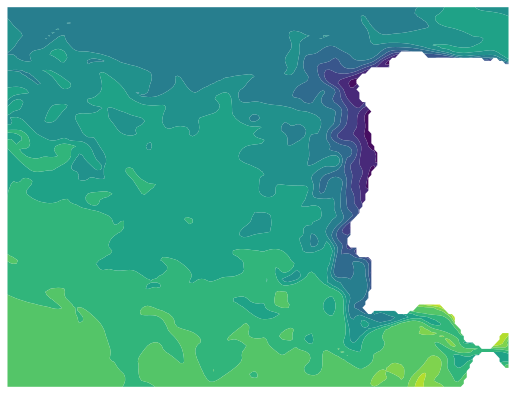

In [15]:
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

plt.rcParams['figure.figsize'] = 9,7 # sets plot size
fig = plt.figure()
ax = fig.add_subplot(111)

# Define levels in z-axis where we want lines to appear
levels = np.array([-0.4,-0.2,0,0.2,0.4])   #como os valores estão super baixos não aparece as linhas a separarem valores no mapa   
#levels = np.array([13, 14, 15, 16, 17, 18, 19, 20])  #permite definir no mapa linhas que separam zonas de diferentes temperaturas

# Generate a color mapping of the levels we've specified
import matplotlib.cm as cm # matplotlib's color map library
cpf = ax.contourf(X,Y,Temp, 12, cmap=cm.viridis)

# Set all level lines to black
#line_colors = ['black' for l in cpf.levels]     

# Make plot and customize axes
#cp = ax.contour(X, Y, Temp,  levels=15)
#ax.clabel(cp, fontsize=10, colors=line_colors);
plt.axis('off')         #Para remover da imagem os labels com a longitude e latitude
#plt.colorbar(cpf, orientation='horizontal', fraction=0.07, pad=0.04, aspect=50)
#plt.title('SST Map 14 December 2019')
 

images_folder = os.path.join(current_path, "../images")
plt.savefig(os.path.join(images_folder, "SST_July10.png"))

### Aplicar Canny Edge Detector a imagem (.png) do dia 14 obtida através do Seaborn

No entanto o meu objectivo não é aplicar o Canny edge detector a imagens (.png), pois ao gravar a imagem eu perco as dimensões verdadeiras da matriz da Temperatura (a imagem fica nomeadamente com 3 dimensões (RGB))

O objetivo é aplicar o Canny a um numpy array que é uma representação dessa imagem.

In [16]:
SST_july10 = cv2.imread(os.path.join(images_folder, "SST_July10.png"))
SST_july10

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [17]:
SST_july10.shape

(504, 648, 3)

In [18]:
x = os.path.join(images_folder, "SST_July14.png")
x

'/home/luisfigueiredo/JUNO/notebooks/../images/SST_July14.png'

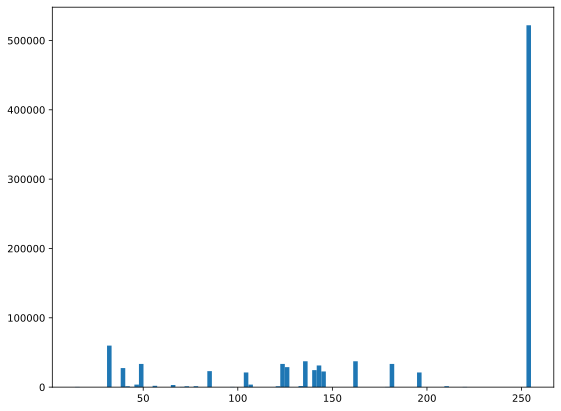

In [19]:
plt.hist(SST_july10.flatten(), bins=100);

NameError: name 'Temp_aux5' is not defined

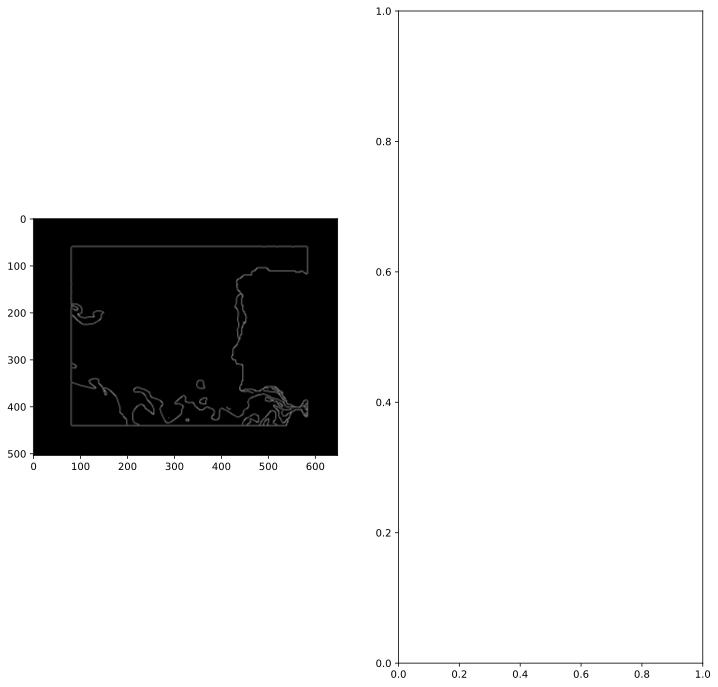

In [20]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
canny = cv2.Canny(SST_july10, 75, 200, L2gradient=False, apertureSize=3)
plt.imshow(canny,"gray")    #'gray'-> parametro para por a preto e branco
plt.subplot(1,2,2)
canny_2 = cv2.Canny(Temp_aux5, 30, 80, L2gradient=False, apertureSize=3)
plt.imshow(canny_2,"gray")    #'gray'-> parametro para por a preto e branco

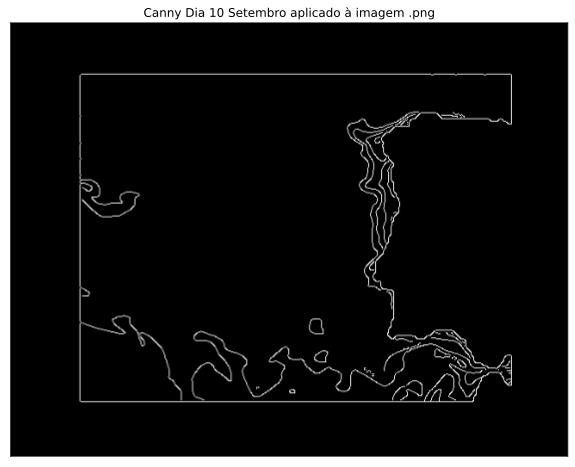

In [21]:
canny = cv2.Canny(SST_july10, 75, 125, L2gradient=False, apertureSize=3)
#apertureSize -> Order of Kernel(matrix) for the Sobel filter. Default value is (3 x 3). value should be odd between 1 and 7
#If use the Default apertureSize is necessary to apply the blurring manually. If vary the size of the Sobel kernel you don't have to perform blurring yourself.
#L2gradient -> specifies the equation for finding gradient magnitude. L2gradient is of boolean type. Its default value is False

plt.rcParams["figure.figsize"] = (10,8)

plt.imshow(canny, 'gray')    #'gray'-> parametro para por a preto e branco
plt.title('Canny Dia 10 Setembro aplicado à imagem .png')
plt.xticks([])
plt.yticks([])
    
plt.show()
#Aplicação do Canny diretamente à imagem previamente guardada

### Aplicar o Canny Algorithm ao numpy array 

Agora vamos aplicar o Canny algorithm no numpy de dimensoes (121, 169) que representa os valores de temperatura

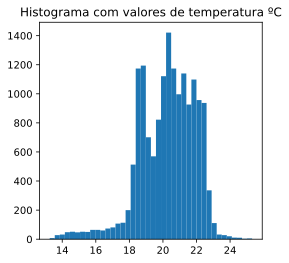

In [31]:
plt.hist(Temp.flatten(), bins=40);
plt.rcParams["figure.figsize"] = 4,4
plt.title('Histograma com valores de temperatura ºC');

#### --------------------------------------------------------------------------------------------------------------
#### Usar um array com o formato uint8 (Valores reais de Temperatura)
#### --------------------------------------------------------------------------------------------------------------

In [32]:
Temp_aux = Temp.copy() #criar um numpy auxiliar que é uma cópia do numpy Temp
Temp_aux

array([[22.594002, 22.516   , 22.59    , ...,       nan,       nan,
              nan],
       [22.617   , 22.52    , 22.555   , ...,       nan,       nan,
              nan],
       [22.641   , 22.531   , 22.519001, ...,       nan,       nan,
              nan],
       ...,
       [18.609001, 18.457   , 18.355   , ..., 19.969002, 19.909   ,
        19.853   ],
       [18.504002, 18.418   , 18.395   , ..., 19.658   , 19.626   ,
        19.611   ],
       [18.461   , 18.434   , 18.484001, ..., 19.441   , 19.421001,
        19.421001]], dtype=float32)

In [33]:
Temp_aux.shape

(121, 169)

In [34]:
#Converter o array para o formato uint8
Temp_aux = Temp_aux.astype(np.uint8)

In [35]:
Temp_aux

array([[22, 22, 22, ...,  0,  0,  0],
       [22, 22, 22, ...,  0,  0,  0],
       [22, 22, 22, ...,  0,  0,  0],
       ...,
       [18, 18, 18, ..., 19, 19, 19],
       [18, 18, 18, ..., 19, 19, 19],
       [18, 18, 18, ..., 19, 19, 19]], dtype=uint8)

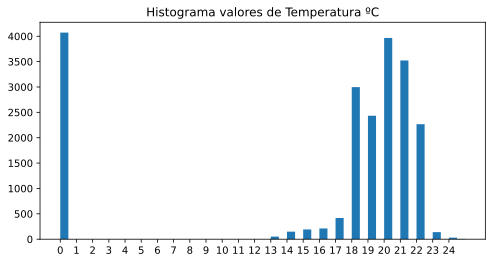

In [37]:
#Para verificarmos que os valores estão de facto entre 0 e 20
plt.hist(Temp_aux.flatten(), bins=50);
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.title('Histograma valores de Temperatura ºC')
plt.rcParams["figure.figsize"] = 8, 4

In [38]:
Temp_aux = np.flipud(Temp_aux)   #flipud -> Reverse the order of elements along axis 0 (up/down).
Temp_aux

array([[18, 18, 18, ..., 19, 19, 19],
       [18, 18, 18, ..., 19, 19, 19],
       [18, 18, 18, ..., 19, 19, 19],
       ...,
       [22, 22, 22, ...,  0,  0,  0],
       [22, 22, 22, ...,  0,  0,  0],
       [22, 22, 22, ...,  0,  0,  0]], dtype=uint8)

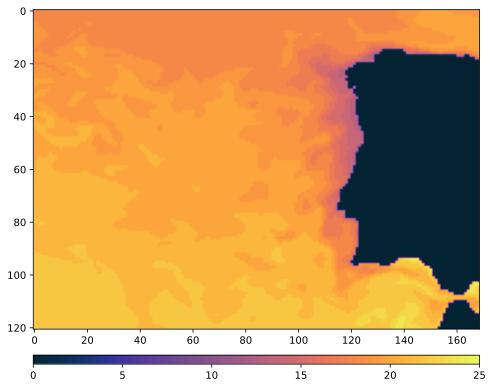

In [40]:
#Plotar o numpy array para ver se de facto corresponde há imagem em causa
import cmocean
im = plt.imshow(Temp_aux, cmocean.cm.thermal)
plt.rcParams["figure.figsize"] = (8,8)
plt.colorbar(im, orientation='horizontal', fraction=0.07, pad=0.06, aspect=50)
plt.show()

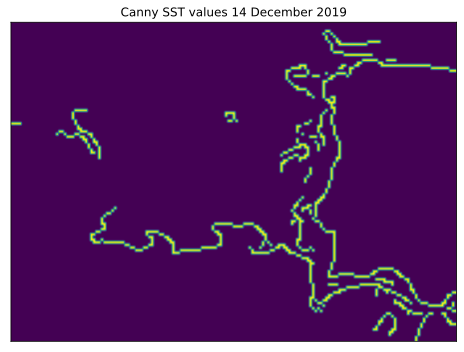

In [41]:
canny = cv2.Canny(Temp_aux, 3, 6, L2gradient=False, apertureSize=3)

plt.rcParams["figure.figsize"] = (8,8)

plt.imshow(canny)    #'gray'-> parametro para por a preto e branco
plt.title('Canny SST values 14 December 2019')
plt.xticks([])
plt.yticks([])
    
plt.show()

#Canny aplicado ao numpy array

#### --------------------------------------------------------------------------------------------------------------
### Usar um array com formato uint8, com valores entre 0 e 255 (MAIS CORRETO)
#### --------------------------------------------------------------------------------------------------------------

In [42]:
# Matriz de temperatura em que os valores estão entre 0 e 255
Temp_aux5 = ((Temp - np.nanmin(Temp)) * (1/(np.nanmax(Temp) - np.nanmin(Temp)) * 255)).astype('uint8')
Temp_aux5

array([[197, 195, 197, ...,   0,   0,   0],
       [197, 195, 196, ...,   0,   0,   0],
       [198, 196, 195, ...,   0,   0,   0],
       ...,
       [113, 110, 107, ..., 142, 140, 139],
       [111, 109, 108, ..., 135, 134, 134],
       [110, 109, 110, ..., 130, 130, 130]], dtype=uint8)

In [43]:
def canny_visualization(df, Tmax):
    
    """
    Função que pega numa df com as temperaturas relativas a um certo dia e plota um mapa com as edges definidas
    através do Canny Algorithm
    """
    
    plt.rcParams["figure.figsize"] = 6, 6
    
    #Pegar na df dum dia e converte-la num np array com os valores de Temperatura para os valores de long e lati
    Temp = df.pivot_table(index='longitude', columns='latitude', values='thetao').T.values
    
    #Converter os valores de temperatura no formato uint8 com valores entre 0-255
    Temp_day = ((Temp - np.nanmin(Temp)) * (1/(np.nanmax(Temp) - np.nanmin(Temp)) * 255)).astype('uint8')

    Temp_day = np.flipud(Temp_day)   #flipud -> Reverse the order of elements along axis 0 (up/down).
    
    #apply the canny algorithm and plot the image with the edges
    canny = cv2.Canny(Temp_day, Tmax/2, Tmax, L2gradient=False, apertureSize=3)
    plt.imshow(canny, 'gray')    #'gray'-> parametro para por a preto e branco
    plt.axis('off');


In [44]:
#Para analisarmos os dados relativos ao dia 2019-12-14
dia8 = datadf2[datadf2['time'] == '2019-09-08 12:00:00']
dia8

,time,latitude,longitude,thetao
250,2019-09-08 12:00:00,35.0,-19.000000,22.789001
608,2019-09-08 12:00:00,35.0,-18.916666,22.652000
966,2019-09-08 12:00:00,35.0,-18.833334,22.621000
1324,2019-09-08 12:00:00,35.0,-18.750000,22.723000
1682,2019-09-08 12:00:00,35.0,-18.666666,22.847000
...,...,...,...,...
7319202,2019-09-08 12:00:00,45.0,-5.333334,20.053001
7319560,2019-09-08 12:00:00,45.0,-5.250000,20.005001
7319918,2019-09-08 12:00:00,45.0,-5.166667,19.959999
7320276,2019-09-08 12:00:00,45.0,-5.083334,19.923000


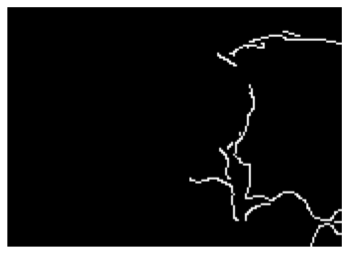

In [45]:
canny_visualization(dia8, 200)

In [46]:
Temp_aux5 = np.flipud(Temp_aux5)   #flipud -> Reverse the order of elements along axis 0 (up/down).
Temp_aux5

array([[110, 109, 110, ..., 130, 130, 130],
       [111, 109, 108, ..., 135, 134, 134],
       [113, 110, 107, ..., 142, 140, 139],
       ...,
       [198, 196, 195, ...,   0,   0,   0],
       [197, 195, 196, ...,   0,   0,   0],
       [197, 195, 197, ...,   0,   0,   0]], dtype=uint8)

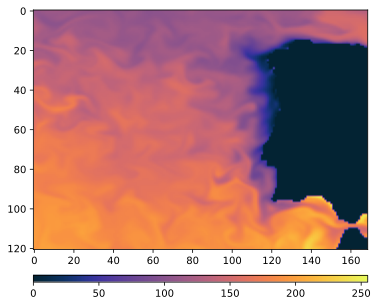

In [47]:
#Plotar o numpy array para ver se de facto corresponde há imagem em causa
im3 = plt.imshow(Temp_aux5, cmocean.cm.thermal)
plt.rcParams["figure.figsize"] = (7,7)
plt.colorbar(im3, orientation='horizontal', fraction=0.07, pad=0.08, aspect=50)
plt.show()

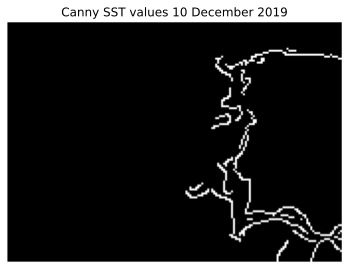

In [48]:
canny3 = cv2.Canny(Temp_aux5, 75, 150, L2gradient=False, apertureSize=3)
plt.rcParams["figure.figsize"] = (6,6)
plt.imshow(canny3, 'gray')    #'gray'-> parametro para por a preto e branco
plt.title('Canny SST values 10 December 2019')
plt.axis('off');    # = plt.xticks([]) plt.yticks([])

#### Sobre thresholds
Os thresholds não são aplicados aos valores de intensidade dos pixels da imagem original mas sim ao seu gradiente de magnitude, cujo valor máximo pode ser entre 4 a 6 vezes superior ao valor máximo da intensidade da imagem, pois são estimados usando um Sobel operator. Assim irão deixar de ser vistas edges quando o upper threshold exceder cerca de 1000 e pouco.

Teoricamente o valor máximo que o Sobel Gradient Magnitude pode atingir é 6 vezes o valor da máxima intensidade da imagem original

### Resultados the canny:
    15 May -> lixo (quase não se conseguem detetar edges)
    30 May -> Mau (algumas edges na costa Sul portuguesa)
    10 June -> Medio/Mau (algumas edges mas a costa portuguesa fica mal definida por vezes)
    30 June -> Lixo (quase não se detetam edges)
    July -> bad results
    10 Agosto -> Medio/Mau (algumas edges mas a costa portuguesa fica mal definida por vezes)
    30 Agosto -> Medio (detetam-se edges na costa Sul portuguesa)
    15 Setembro -> médio (detetam-se edges ao longo da costa mas a costa esta mal definida em alguns sitios)
    30 Setembro -> médio (detetam-se varias edges mas a costa esta mal definida em alguns sitios)
    15 Outubro -> médio/mau (detetam-se edges ao longo da costa mas a costa esta mal definida em alguns sitios)
    30 Outubro -> médio/bom (detetam-se edges e a costa encontra-se relativamente bem definida)

# --------------------------------------------------------------------------------------------------------
### Para Interpretação

Nesta célula serão visualizados 4 plots relativos a um dia específico: 2 imagens sujeitas ao canny algorithm com diferentes valores de thresholds (para analisarmos as diferenças), 1 contour da imagem das SST cujos valores de temperaturas estão nas suas gamas corretas e 1 histograma com a dispersão dos valores de temperatura quando convertidos para a gama 0-255. 


In [40]:
canny_300 = []
for line in canny_1:
    print(line)
    canny_300.append(line[line == 0] = np.nan)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (45687995.py, line 4)

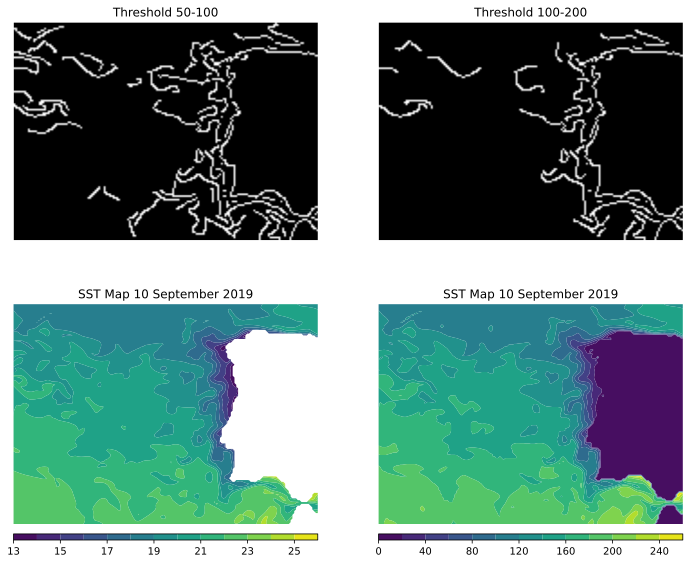

In [49]:
# create figure
fig = plt.figure(figsize=(12, 10))

# setting values to rows and column variables
rows = 2
columns = 2

#apertureSize -> Order of Kernel(matrix) for the Sobel filter. Default value is (3 x 3). value should be odd between 3 and 7
#L2gradient -> specifies the equation for finding gradient magnitude. L2gradient is of boolean type. Its default value is False

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
#Definição dos parametros do canny
Tmax = 78
Tmin= Tmax/2

canny_1 = cv2.Canny(Temp_aux5, Tmin, Tmax, L2gradient=False, apertureSize=3)
# showing image
plt.imshow(canny_1, 'gray')
plt.axis('off')
plt.title("Threshold 50-100");

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
Tmax = 100
Tmin= Tmax/2

#Definição dos parametros do canny
canny_2 = cv2.Canny(Temp_aux5, Tmin, Tmax, L2gradient=False, apertureSize=3)
# showing image
plt.imshow(canny_2, 'gray')
plt.axis('off')
plt.title("Threshold 100-200");


# Adds a subplot to show the image

ax = fig.add_subplot(rows, columns, 3)
# Generate a color mapping of the levels we've specified
cpf = ax.contourf(X,Y,Temp, 14, cmap=cm.viridis)
# Make plot and customize axes
#cp = ax.contour(X, Y, Temp,  levels=levels, colors=line_colors)
#ax.clabel(cp, fontsize=10, colors=line_colors);
plt.axis('off');       #Para remover da imagem os labels com a longitude e latitude
plt.colorbar(cpf, orientation='horizontal', fraction=0.07, pad=0.04, aspect=50)
plt.title('SST Map 10 September 2019');


# Adds a subplot at tshow um histograma com a dispersão dos valores de temperatura na matriz da imagem
ax=fig.add_subplot(rows, columns, 4)
#Definição dos parametros do canny
cpf = ax.contourf(X,Y,np.flipud(Temp_aux5), 14, cmap=cm.viridis)
plt.axis('off');       #Para remover da imagem os labels com a longitude e latitude
plt.colorbar(cpf, orientation='horizontal', fraction=0.07, pad=0.04, aspect=50)
plt.title('SST Map 10 September 2019');


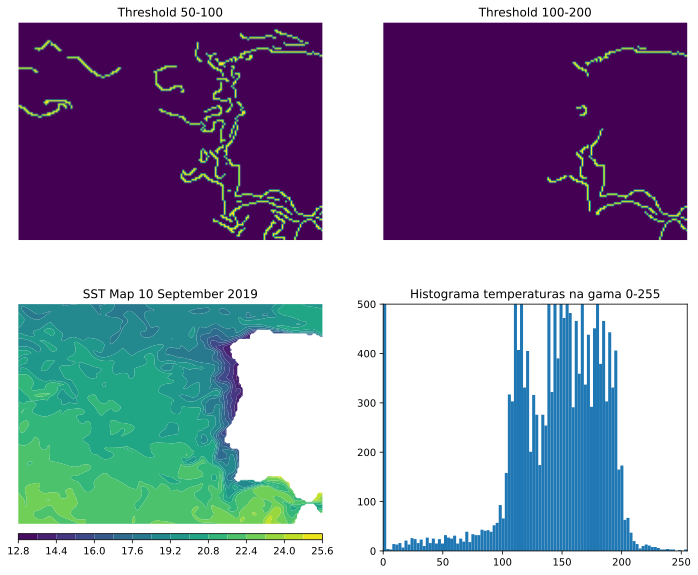

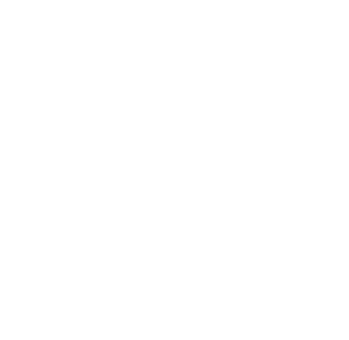

In [50]:
# create figure
fig = plt.figure(figsize=(12, 10))

# setting values to rows and column variables
rows = 2
columns = 2

#apertureSize -> Order of Kernel(matrix) for the Sobel filter. Default value is (3 x 3). value should be odd between 3 and 7
#L2gradient -> specifies the equation for finding gradient magnitude. L2gradient is of boolean type. Its default value is False

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
#Definição dos parametros do canny
canny_1 = cv2.Canny(Temp_aux5, 50, 100, L2gradient=False, apertureSize=3)
# showing image
plt.imshow(canny_1)
plt.axis('off')
plt.title("Threshold 50-100");

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
#Definição dos parametros do canny
canny_2 = cv2.Canny(Temp_aux5, 100, 200, L2gradient=False, apertureSize=3)
# showing image
plt.imshow(canny_2)
plt.axis('off')
plt.title("Threshold 100-200");


# Adds a subplot to show the image

ax = fig.add_subplot(rows, columns, 3)
# Generate a color mapping of the levels we've specified
cpf = ax.contourf(X,Y,Temp, 15, cmap=cm.viridis)
# Make plot and customize axes
#cp = ax.contour(X, Y, Temp,  levels=levels, colors=line_colors)
#ax.clabel(cp, fontsize=10, colors=line_colors);
plt.axis('off');       #Para remover da imagem os labels com a longitude e latitude
plt.colorbar(cpf, orientation='horizontal', fraction=0.07, pad=0.04, aspect=50)
plt.title('SST Map 10 September 2019');


# Adds a subplot that shows histograma com a dispersão dos valores de temperatura na matriz da imagem (0-255)
fig.add_subplot(rows, columns, 4)
#Definição dos parametros do canny
histograma = plt.hist(Temp_aux5.flatten(), bins=100);
plt.xlim([0, 255])
plt.ylim([0, 500])
# showing image
plt.title("Histograma temperaturas na gama 0-255");
plt.show(histograma);
plt.axis('off');


# ---------------------------------------------------------------------------
### Blog de Finding Oceanic fronts with Edge Detection Techniques

In [51]:
from IPython.display import display
from IPython.html.widgets import interact, fixed

#cbarkw = dict(shrink=0.73, extend='both')

def canny_threshold(image, threshold=30, ratio=3, ksize=3):
    
    detected_edges = cv2.Canny(Temp_aux5, threshold,
                               threshold*ratio,
                               apertureSize=ksize)
    # Just add some colours to edges from original data.
    mask = np.ma.masked_equal(detected_edges, 0).mask
    img = np.ma.masked_array(Temp_aux5, mask)
    
    fig, ax = plt.subplots(figsize=(10,8))
    cs = ax.imshow(img)
    #cbar = fig.colorbar(cs, ax=ax, **cbarkw)
    ax.axis('off')
    plt.show()

lims = (0, 100)
w = interact(canny_threshold, threshold=lims,
             image=fixed(Temp_aux5),
             ratio=fixed(3), ksize=fixed(3))

display(w)

/home/luisfigueiredo/.local/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


interactive(children=(IntSlider(value=30, description='threshold'), Output()), _dom_classes=('widget-interact'…

<function __main__.canny_threshold(image, threshold=30, ratio=3, ksize=3)>

# ---------------------------------------------------------------------------------------
## Otsu Method
Is an algorithm to automatically find the optimal threshold intensity

It searches for the threshold intensity that optimally separates the image into two classes (the foreground and the background). Does this by maximizing a matrix called between class variance.
Is optimal in the sense that it does the best possible job to split the foreground and the background assuming a bi-modal distribution of grayscale pixel values.

The Otsu algorithm calculate the high threshold, and then it can be used in the Canny algorithm to detect the object’s edge

Otsu method makes the assumption that the grayscalle histogram of our pixel intensities of our image is bi-modal (the histogram has 2 peaks) --> o que no caso da nossa imagem não é verdade.
If it doesn't follow a bi-modal distribution the Otsu's method may not give us the best results. 

So we should try Adaptive thresholding.

In situations where lighting conditions are semi-stable and the objects we want to segment have sufficient contrast from the background we might not need to use Otsu's method.

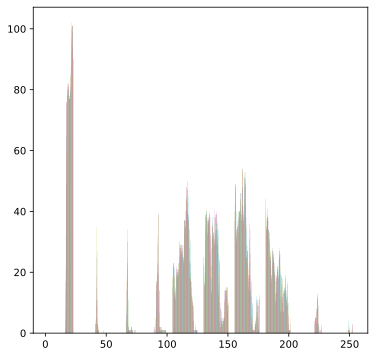

In [52]:
plt.hist(Temp_aux5);

In [53]:
bins_num = 256

#Get the image histogram
hist, bin_edges = np.histogram(Temp_aux5, bins=bins_num)

#Calculate centers of Bins
bin_mids = (bin_edges[:-1] + bin_edges[1:])/2

#iterate through all thresholds (indices) and get the probabilities w1(t), w2(t)
weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]

#Get the class means mu0(t)
mean1 = np.cumsum(hist*bin_mids)/weight1
#get the class means mu1(t)
mean2 = (np.cumsum((hist*bin_mids)[::-1])/weight2[::-1])[::-1]

inter_class_variance = weight1[:-1]*weight2[1:]*(mean1[:-1] - mean2[1:])**2

#Maximize the inter_class_variance function val
index_of_max_val = np.argmax(inter_class_variance)

threshold = bin_mids[:-1][index_of_max_val]
print('Otsu algorithm implementation thresholding result: ', threshold)

Otsu algorithm implementation thresholding result:  78.193359375


In [54]:
#Outra forma de obter o Otsu's thresolding atraves do openCV
otsu_threshold, image_result = cv2.threshold(Temp_aux5, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,)
print('Obtained threshold: ', otsu_threshold)

Obtained threshold:  78.0


In [ ]:
#Estes valores (78) correspondem ao threshold high


## Adaptive Thresholding

Adaptive Thresholding considers a small set of neighboring pixels at a time, computes T for that specific local region, and then performs the segmentation.

But since we are using Canny Algorithm this isn't a viable option

# --------------------------------------------------------------------------------------------------------
### Tentar relacionar temperaturas verdadeiras com as convertidas para formato grayscale 0-255 ?????????

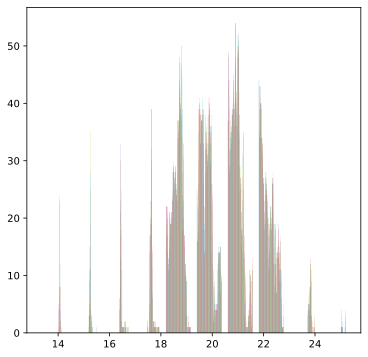

In [55]:
plt.hist(Temp);

In [56]:
np.nanmax(Temp), np.nanmin(Temp)   #valores verdadeiros da temperatura

(25.313, 13.253)

In [57]:
np.max(Temp_aux5), np.min(Temp_aux5)

(255, 0)

In [58]:
(np.nanmax(Temp) - np.nanmin(Temp))/255
#1 valor de intensidade de um pixel na gama 0-255 corresponde a 0,0473ºC

0.047294115552715225

In [ ]:
#Eu teria de ver o que é que o Sobel Operator faz aos pixels

# ---------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------------------------
### Apply Gaussian Filter previously

No paper de Madagascar eles dizem aplicar um gaussian filter às imagens antes de aplicar o Canny Algorithm (to omit small scale variability)

In [59]:
from scipy.ndimage import gaussian_filter

In [60]:
Temp_gauss = Temp_aux5.copy()
Temp_gauss

array([[110, 109, 110, ..., 130, 130, 130],
       [111, 109, 108, ..., 135, 134, 134],
       [113, 110, 107, ..., 142, 140, 139],
       ...,
       [198, 196, 195, ...,   0,   0,   0],
       [197, 195, 196, ...,   0,   0,   0],
       [197, 195, 197, ...,   0,   0,   0]], dtype=uint8)

In [61]:
Temp_gauss = gaussian_filter(Temp_gauss, sigma=1)
Temp_gauss
#Quando aplico este Gaussian_filter a gama de valores do array passa a estar entre 0-229

array([[109, 109, 109, ..., 132, 131, 131],
       [110, 109, 108, ..., 135, 134, 134],
       [112, 110, 108, ..., 140, 139, 138],
       ...,
       [196, 195, 196, ...,   0,   0,   0],
       [196, 195, 196, ...,   0,   0,   0],
       [196, 196, 196, ...,   0,   0,   0]], dtype=uint8)

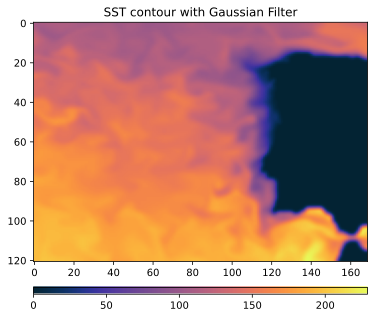

In [62]:
#Plotar o numpy array para ver se de facto corresponde há imagem em causa
im5 = plt.imshow(Temp_gauss, cmocean.cm.thermal)
plt.rcParams["figure.figsize"] = (7,7)
plt.colorbar(im5, orientation='horizontal', fraction=0.07, pad=0.08, aspect=50)
plt.title('SST contour with Gaussian Filter')
plt.show()

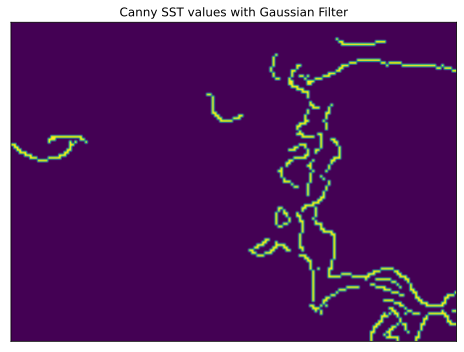

In [63]:
canny7 = cv2.Canny(Temp_gauss, 40, 80, L2gradient=False, apertureSize=3)

plt.rcParams["figure.figsize"] = (8,8)

plt.imshow(canny7)    #'gray'-> parametro para por a preto e branco
plt.title('Canny SST values with Gaussian Filter')
plt.xticks([])
plt.yticks([])
    
plt.show()

#### Mostrar diferença de resultados: Normal vs Prévia aplicação dum Gaussian Filter

Podemos observar as diferenças que surgem nos resultados do canny quando é previamente aplicado um Gaussian Filter ao array.  Gaussian filter is commonly used in image processing for smoothing and reducing noise.

No StackOverflow dizem que se usarmos um apertureSize superior a 3 (5 ou 7) então não é necessário aplicar um Gaussian Blur. Se se usar um apertureSize=3 então é necessário aplicar previamente um Gaussian Blur. Existem algumas fontes que contradizem esta informação.

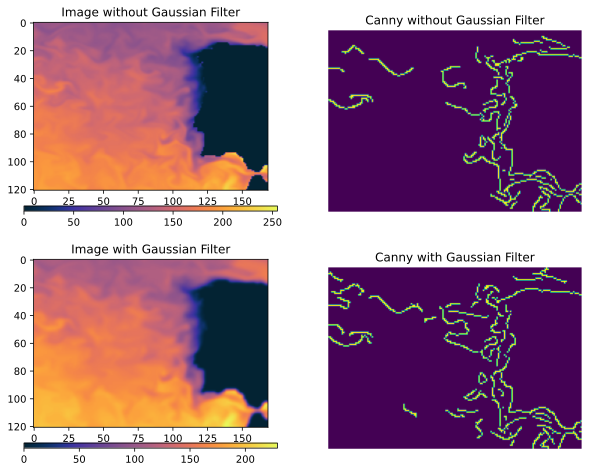

In [64]:
# create figure
fig = plt.figure(figsize=(10, 8))

# setting values to rows and column variables
rows = 2
columns = 2

#apertureSize -> Order of Kernel(matrix) for the Sobel filter. Default value is (3 x 3). value should be odd between 3 and 7
#L2gradient -> specifies the equation for finding gradient magnitude. If True uses a more accurate equation; Default value is False
        # With L2gradient=True the algorithm shows less edges

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
im3 = plt.imshow(Temp_aux5, cmocean.cm.thermal);
plt.colorbar(im3, orientation='horizontal', fraction=0.07, pad=0.08, aspect=50);
plt.title('Image without Gaussian Filter');


# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
#Definição dos parametros do canny
canny_2 = cv2.Canny(Temp_aux5, 50, 100, L2gradient=False, apertureSize=3)
# showing image
plt.imshow(canny_2)
plt.axis('off');
plt.title("Canny without Gaussian Filter");


# Adds a subplot to show the image
ax = fig.add_subplot(rows, columns, 3)
im5 = plt.imshow(Temp_gauss, cmocean.cm.thermal)
plt.colorbar(im5, orientation='horizontal', fraction=0.07, pad=0.08, aspect=50)
plt.title('Image with Gaussian Filter');

# Adds a subplot at tshow um histograma com a dispersão dos valores de temperatura na matriz da imagem
fig.add_subplot(rows, columns, 4)
#Definição dos parametros do canny
canny7 = cv2.Canny(Temp_gauss, 30, 60, L2gradient=False, apertureSize=3)
plt.imshow(canny7)    #'gray'-> parametro para por a preto e branco
plt.axis('off');
plt.title('Canny with Gaussian Filter');


# ------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------
## Fazer o overlay das imagens com o canny

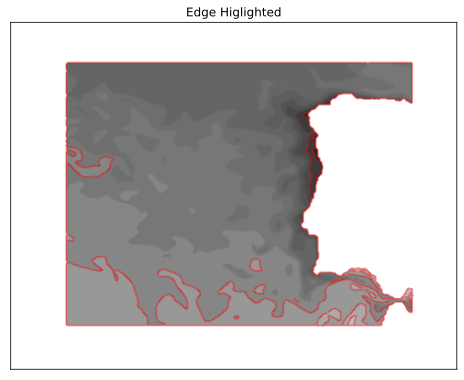

In [65]:
#fig = plt.figure(figsize=(10, 8))
plt.rcParams["figure.figsize"] = 8,8

SST_png = cv2.imread(os.path.join(images_folder, "SST_July10.png"),0)
edges = cv2.Canny(SST_png, 50, 100)


img = cv2.merge((SST_png, SST_png, SST_png))
img2 = img.copy()
img2[edges==255] = [255, 0, 0]     #turn edges to red


plt.imshow(img2)
plt.title('Edge Higlighted'), plt.xticks([]), plt.yticks([])

plt.show()

Só consigo fazer a sobreposição entre a imagem .png e o canny aplicado a essa mesma imagem .png porque estas precisam de ter as mesmas dimensões. Depois tentar fazer isto com os arrays em vez de com os .png

In [ ]:
# Fazer overlay como naquele blog 

#Mas estes contours que aparecem aqui não são os obtidos no Canny.

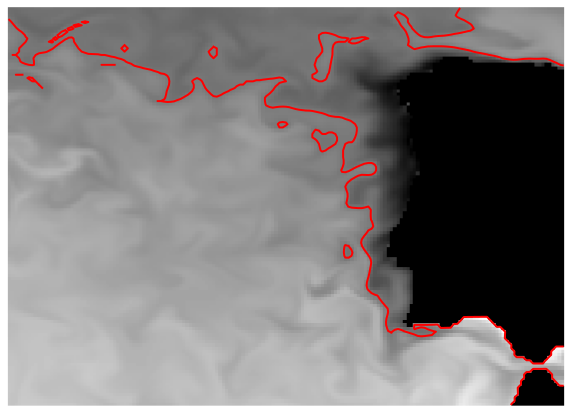

In [66]:

from skimage import measure

contours = measure.find_contours(np.flipud(Temp_aux5), 120)

fig, ax = plt.subplots(figsize=(10,8))
kw = dict(interpolation='nearest', cmap=plt.cm.gray,
          origin='lower')
ax.imshow(np.flipud(Temp_aux5), **kw)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='r')

_ = ax.axis('off')

In [ ]:
#

In [67]:
# Reading the images that are present
source1 = Temp_aux5
source2 = cv2.Canny(Temp_aux5, 75, 150, L2gradient=False, apertureSize=3)
# blending the image by adding necessary weights
dest = cv2.addWeighted(source1, 0.5, source2, 0.5, 0.0)
# saving the output of the image
cv2.imwrite('overlay_img.png', dest) 
cv2.imshow('overlay_img.png', ims)
 

from IPython.display import Image
Image(filename='overlay_img.png') 


NameError: name 'ims' is not defined

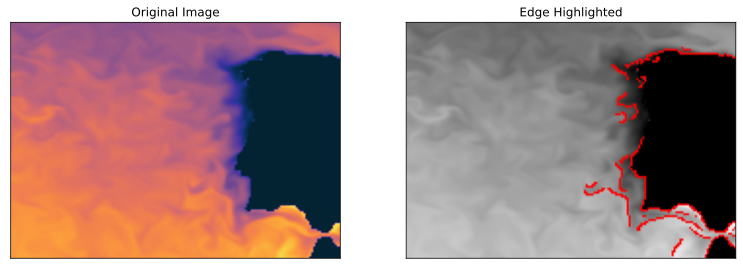

In [68]:

img = Temp_aux5
edges = cv2.Canny(Temp_aux5, 100, 150)   # canny edge detector

fig = plt.subplots(figsize=(13,10))
#plt.rcParams["figure.figsize"] = 12, 20

img = cv2.merge((img,img,img))  # creat RGB image from grayscale
img2 = img.copy()
img2[edges == 255] = [255, 0, 0]  # turn edges to red

plt.subplot(121),plt.imshow(Temp_aux5, cmocean.cm.thermal)
plt.title('Original Image'), plt.xticks([]), plt.yticks([]);
plt.subplot(122),plt.imshow(img2)
plt.title('Edge Highlighted'), plt.xticks([]), plt.yticks([])

plt.show()

# ----------------------------------------------------------------------------------------------------
### Código para que dada uma dataframe, esta seja dividida em várias dataframes consoante a data

Os dados que eu vou extrair do satelite serão referentes a vários dias diferentes portanto para facilitar o posterior processamento dos dados, esta função vai me permitir dividir a dataframe original em diversas dataframes conforme a data

In [ ]:
datadf2

In [ ]:
#converter a coluna time para string (pode simplificar)
datadf2['time']=datadf2['time'].astype(str)

In [ ]:
#Criar uma lista com as diferentes datas
unique_dates = datadf2['time'].unique()
list_dates = list(unique_dates)
list_dates

In [ ]:
n_unique = datadf2['time'].nunique()
n_unique    #nº de datas diferentes que há na dataframe

In [ ]:
splits = list(datadf2.groupby("time"))   # divide a dataframe de acordo com a coluna 'time' e agrupa a informação numa lista

In [ ]:
d = {}
for i in range(n_unique):
    for time in list_dates:
        d[time] = pd.DataFrame(splits[i][1])

In [ ]:
d

In [ ]:
for key in d.keys():
    d[key] = datadf2[:][datadf2.time == key]

In [ ]:
d['2019-07-14 12:00:00']  

In [ ]:
d['2019-07-14 12:00:00'].info()    #trata-se duma dataframe

# ----------------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------------
### Transformar as coordenadas (longitude e latitude) numa tupple de Pixels (x,y)

In [ ]:
#Criar 2 novas colunas X e Y que sejam os pixels correspondentes

lons = dia10["longitude"].astype("float32").unique()
lats = dia10["latitude"].astype("float32").unique()
lons.sort()
lats.sort()
def get_pixels(lons, lats):
    pixels = {}
    for x, lon in enumerate(lons):
        for y, lat in enumerate(lats):
            pixels[(lon, lat)] = (x, y)
    return pixels
def get_x(lon, lat, pixels):
    return pixels[(lon, lat)][0]
def get_y(lon, lat, pixels):
    return pixels[(lon, lat)][1]
pixels = get_pixels(lons, lats)
dia10["x"] = dia10.apply(lambda row: get_x(row["longitude"], row["latitude"], pixels), axis=1)
dia10["y"] = dia10.apply(lambda row: get_y(row["longitude"], row["latitude"], pixels), axis=1)

In [ ]:
#Converter as colunas x e y para uma nova coluna no formato de tupple
dia10['Pixels'] = dia10[['x', 'y']].apply(tuple, axis=1)

In [ ]:
dia10

# --------------------------------------------------------------------------------------

A fazer: 

    * Testar fazer a sobreposição das imagens com o canny (done)
    * Ler os papers para perceber como é que eles escolhem os thresholds e porquê. E tentar compreender o significado fisico do threshold
    * Converter a imagem RGB para Grayscale e visualizar os resultados do Canny de ambas
    * Criar uma função para o Canny Visualization
    * Tentar converter os zeros para Null Values na imagem e ver o que se obtem --> Canny não aceita Null Values pois os arrays tem de estar no formato uint8 e esse formato nao permite Null Values